In [ ]:
# conda create --name Env_VectoRaster

In [ ]:
#conda create -n envFjell
#conda activate envFjell
#conda config --env --add channels conda-forge
#conda config --env --set channel_priority strict
#conda install geopandas
##conda install pyogrio # følger med geopandas
#conda install fiona
#conda install rasterio
# conda install pyarrow

In [7]:
import geopandas as gpd
import pyogrio
import fiona
import rasterio as rio
import numpy as np 
# import pyarrow
# pyarrow fungerer ikke i min conda env
import os

In [242]:
import pandas as pd
arter = pd.read_excel("C:/data/Artsliste_Naturtyper_fra_ADB_20220629_vers2.xlsx", sheet_name="Artslister_NiN")

In [243]:
#
# Fjern de som mangler kategori
arter = arter[~arter["Kategori"].isna()]
# Behold de som er relevant mtp kalkgradienten
arter = arter[arter["Kategori"].str.contains("KA")]
# Behold den som er kjennetegnede for skille og tyndepunktsgradient
arter = arter[arter["Kategori"].str.contains("s|t¤")]
# Function to find "KA" and extract the part 2-4 positions behind it
def extract_behind_ka(s, find = "KA", pos1=3, pos2=6):
    kid = s.find(find)
    return s[(kid+pos1):(kid+pos2)]
    #else:
    #    return None
# Apply the function to the 'Kategori' column
arter['KA_Skille'] = arter['Kategori'].apply(extract_behind_ka, find = "KA", pos1 = 3, pos2 = 6)
arter['KA_Skillestyrke'] = arter['Kategori'].apply(extract_behind_ka, find = "KA", pos1 = -3, pos2 = -1)
arter['KA_Skilletrinn']=arter['KA_Skille'].apply(lambda x: x[0])

#t¤

In [244]:
#arter[['Populærnavn', "VitNavn","KE","KE_kode",  "KA_Trinn", "KA_Styrke"]].drop_duplicates()

arter[['Populærnavn', "VitNavn",'KA_Skille',  "KA_Skilletrinn", "KA_Skillestyrke"]].drop_duplicates()

,Populærnavn,VitNavn,KA_Skille,KA_Skilletrinn,KA_Skillestyrke
0,Granmose,Abietinella abietina,h|g,h,s-
6,Granmose,Abietinella abietina,g|f,g,s-
7,Granmose,Abietinella abietina,f|e,f,s*
19,Granmose,Abietinella abietina,h|g,h,s*
26,Ryllik,Achillea millefolium,d|c,d,s+
...,...,...,...,...,...
6870,Engtjæreblom,Viscaria vulgaris,d|c,d,s+
6882,Vassnøkkemose,Warnstorfia fluitans,d|e,d,s-
6883,Vassnøkkemose,Warnstorfia fluitans,d|e,d,s+
6884,Tannkrusmose,Weissia controversa,g|f,g,s+


In [245]:
# Beholder bare de som er skille mellom hovedtrinn langs gradienten, Utelat de som er skiller innad i gradienten
# arter = arter[~arter['KA_Skilletrinn'].str.contains("e|h")]
#arter[arter["KA_Skille	"].str.contains("g")] & arter[arter["KA_Skille"].str.contains("h")]

In [246]:
# Fjern det som ikke er på artsnivå
arter = arter[arter["VitNavn"].apply(lambda x: " " in x)]
#arter = arter[]
utvalg = arter[arter['KA_Skillestyrke']!="s-"]["VitNavn"].drop_duplicates()


In [253]:
utvalg[2:4]
#utvalg[0:4]

50     Aconitum septentrionale
103         Agrostis mertensii
Name: VitNavn, dtype: object

In [297]:
# Use groupby and sample to get one row per group
utvalg = arter.groupby('KA_Skillestyrke').apply(lambda x: x.sample(n=1)).reset_index(drop=True)["VitNavn"]

C:\Users\endre\AppData\Local\Temp\ipykernel_20860\3226269279.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  utvalg = arter.groupby('KA_Skillestyrke').apply(lambda x: x.sample(n=1)).reset_index(drop=True)["VitNavn"]


# GBIF

In [313]:
# set up request function
import requests
import pandas as pd
base_url = "https://api.gbif.org/v1/occurrence/search?"
countryCode = "NO"
def get_GBIF_response(base_url, offset, params, df, maxCount = None, i = None):
    """Performs an API call to the base URL with additional parameters listed in 'params'. Concatenates response to a Pandas DataFrame, 'df'."""
    
    #Construct the query URL
    query = base_url+'&'+f'offset={offset}'
    for each in params:
        query = query+'&'+each
            
    #Call API
    #print(query)
    response = requests.get(query)
    
    #If call is successful, add data to df
    if response.status_code != 200:
        print(f"API call failed at offset {offset} with a status code of {response.status_code}.")
    else:
        result = response.json()
        df2 = pd.DataFrame.from_dict(result['results'])
        if i is not None:
            df2['query'] = i
        df_concat = pd.concat([df, df2], axis = 0, ignore_index = True, sort = True)
        endOfRecords = result['endOfRecords']
        return df_concat, endOfRecords, response.status_code
#set parameters for API call
params0 = ['limit=100', 'publishingCountry=NO','hasGeospatialIssue=false', 'hasCoordinate=true','year=2010,2025','coordinateUncertaintyInMeters=0,250', 'county=Trøndelag']

In [ ]:
# https://api.gbif.org/v1/occurrence/search?scientificName=Herminium%20monorchis&publishingCountry=NO&hasCoordinate=true&hasGeospatialIssue=false

In [315]:
#Set up a simple while loop to continue downloading until the last #page
df = pd.DataFrame()
endOfRecords = False
offset = 0
status = 200
# species to check
species = utvalg#[5:10]
# prefix for the request parameter
pre = 'scientificName='

for i in species:
    print(i)
    params = params0.copy()
    params.append(pre+i)
    while endOfRecords == False and status == 200:
        df, endOfRecords, status = get_GBIF_response(base_url, offset, params, df, i = i,maxCount = 100)
        endOfRecords = True # kommenterer bort denne når jeg vil begrense antall treff, og ikke ha alt
        print(offset)
        offset = len(df) + 1
    endOfRecords = False
    offset = 0
    status = 200

Carex flava
0
Pilosella officinarum
0
Draba verna
0
Anthoxanthum nipponicum
0
Sphagnum compactum
0
Peltigera praetextata
0
Lathyrus linifolius
0


In [316]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['decimalLongitude'], df['decimalLatitude']))
gdf = gdf.query('decimalLongitude > 0 & decimalLatitude > 55 & coordinateUncertaintyInMeters<250')


In [317]:
gdf = gdf.merge(arter, left_on = 'query', right_on = 'VitNavn')
gdf = gdf.sort_values(by = 'KA_Skilletrinn') 

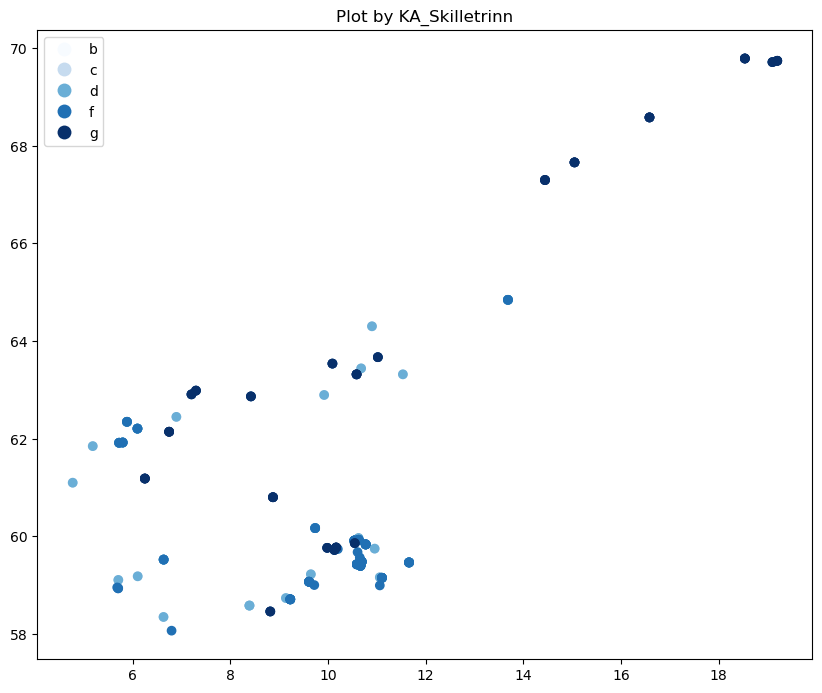

In [318]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have a GeoDataFrame named 'gdf' with the column 'KA_Skilletrinn'
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='KA_Skilletrinn', cmap='Blues', legend=True, ax=ax)
plt.title('Plot by KA_Skilletrinn')
plt.show()
